# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


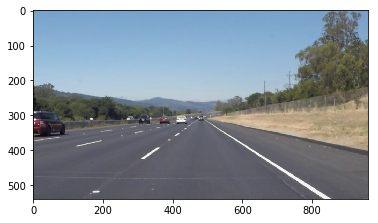

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines_raw(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
            
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    imshape = img.shape
    # global variables is needed because I'm going to compare 
    #slopes of every line in the lane to previous slopes
    global prev_mean_right_slope
    global prev_mean_left_slope
    #initialization of slope change limit is needed to eliminate 
    #noise since the direction of the lane on the road wouldn't change very quickly
    slope_change_limit = 0.2 # considering that the slope wouldn't change 
                            #more quickly than 0.2 radians (about 13 degrees) per frame (about every 0.4 second);
    if not lines is None:
        if len(lines) > 0:
            right_slopes = [] 
            left_slopes = [] 
            right_intercepts = []
            left_intercepts = []
            right_squared_length_sum = 0 #initialization of sum of squared line lengths 
                                         #for weighing of right slopes
            left_squared_length_sum = 0 #initialization of sum of squared line lengths 
                                         #for weighing of left slopes
            for line in lines:
                for x1,y1,x2,y2 in line:
                    x_diff = x2 - x1
                    if x_diff != 0: #check x_diff to avoid dividing by zero in the slope calculation
                        y_diff = y2 - y1
                        square_length = x_diff**2 + y_diff**2 #if the line is quite long it 
                                                               #contributes more to the mean slope and mean intercept
                        slope = 1.0*y_diff/x_diff
                        intercept = y1 - 1.0*slope*x1
                        right_slope_change = 0 #initialization of the right slope change
                        left_slope_change = 0 #initialization of the left slope change
                        if prev_mean_right_slope != np.float('NaN'):
                            right_slope_change = abs(math.atan(1.0*slope) - math.atan(1.0*prev_mean_right_slope))
                        if prev_mean_left_slope != np.float('NaN'):
                            left_slope_change = abs(math.atan(1.0*slope) - math.atan(1.0*prev_mean_left_slope))
                        #in the condition it is implied that the right line would rather be in the 60% right part of the frame;
                        #the slope for the right line should be positive
                        if (slope > 0) & (imshape[1]*0.4 < x1) & (imshape[1]*0.4 < x2) & \
                                         (not right_slope_change > slope_change_limit): 
                            right_slopes.append(slope*square_length)
                            right_intercepts.append(intercept*square_length)
                            right_squared_length_sum += square_length
                        #in the condition it is implied that the left line would rather be in the 60% left part of the frame;
                        #the slope for the left line should be negative
                        elif (slope < 0) & (x1 < imshape[1]*0.6) & (x2 < imshape[1]*0.6) & \
                                         (not left_slope_change > slope_change_limit):
                            left_slopes.append(slope*square_length)
                            left_intercepts.append(intercept*square_length)
                            left_squared_length_sum += square_length

            y_highest = 0.62*img.shape[0]

            lines_2 = []
            
            #calculate mean right slope and intercept
            if len(right_slopes) > 0:
                mean_right_slope = np.sum(right_slopes) / right_squared_length_sum
                mean_right_intercept = np.sum(right_intercepts) / right_squared_length_sum
                right_line = [(1.0*(img.shape[0] - mean_right_intercept) / mean_right_slope), 
                           img.shape[0],
                           (1.0*(y_highest - mean_right_intercept) / mean_right_slope),
                           y_highest]            
                right_line = np.round(right_line)
                lines_2.append([right_line])
                #prev_mean_left_slope will be used in the next function call to eliminate noisy lines
                prev_mean_right_slope = mean_right_slope
                
            #calculate mean left slope and intercept
            if len(left_slopes) > 0:
                mean_left_slope = np.sum(left_slopes) / left_squared_length_sum       
                mean_left_intercept = np.sum(left_intercepts) / left_squared_length_sum
                left_line = [(1.0*(imshape[0] - mean_left_intercept) / mean_left_slope), 
                           imshape[0],
                           (1.0*(y_highest - mean_left_intercept) / mean_left_slope), 
                           y_highest]
                left_line = np.round(left_line)
                lines_2.append([left_line])
                #prev_mean_left_slope will be used in the next function call to eliminate noisy lines
                prev_mean_left_slope = mean_left_slope

            for line in lines_2:
                for x1,y1,x2,y2 in line:
                    x1 = int(x1)
                    x2 = int(x2)
                    y1 = int(y1)
                    y2 = int(y2)
                    #draw lane lines
                    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# I added raw_lines argument to the hough_lines function to be able to make raw lines
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, raw_lines = False):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    if raw_lines == False:
        draw_lines(line_img, lines)
    else:
        draw_lines_raw(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

run your solution on all test_images and make copies into the test_images directory).

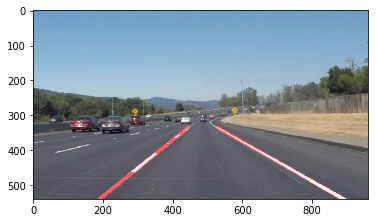

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

#initialization of the previous slopes as NaN (though they will be useful only for video)
prev_mean_right_slope = np.float('NaN')
prev_mean_left_slope = np.float('NaN')

img = mpimg.imread('test_images/solidWhiteCurve.jpg')
img2 = grayscale(img)
img2 = gaussian_blur(img2, kernel_size = 5)
img2 = canny(img2, 50, 150)
imshape = img2.shape
verts = np.array([[(0.13*imshape[1],imshape[0]),(0.45*imshape[1], 0.62*imshape[0]), 
                     (0.57*imshape[1], 0.62*imshape[0]), (0.98*imshape[1],imshape[0])]], 
                     dtype=np.int32)
img2 = region_of_interest(img2, verts)
img2 = hough_lines(img2, rho=1, theta=np.pi/180, threshold=30, min_line_len=70, max_line_gap=50)
img2=weighted_img(img2, img, α=1., β=1., λ=0.)
plt.imshow(img2, cmap='Greys_r')

#Delete global variables
del prev_mean_right_slope
del prev_mean_left_slope

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#### Row line

In [7]:
def process_image_raw_lines(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    low_border_pcnt = 1.0
    img2 = grayscale(image)
    img2 = gaussian_blur(img2, kernel_size = 5)
    img2 = canny(img2, 50, 150)
    imshape = img2.shape
    verts = np.array([[(0.13*imshape[1],imshape[0]*low_border_pcnt),(0.45*imshape[1], 0.62*imshape[0]), 
                         (0.57*imshape[1], 0.62*imshape[0]), (0.98*imshape[1],imshape[0]*low_border_pcnt)]], 
                         dtype=np.int32)
    img2 = region_of_interest(img2, verts)
    img2 = hough_lines(img2, rho=1, theta=np.pi/180, threshold=30, min_line_len=70, max_line_gap=50, raw_lines = True)
    result=weighted_img(img2, image, α=1., β=1., λ=0.)
    return result

In [8]:
raw_lines = 'raw-lines.mp4'
clip1 = VideoFileClip("solidYellowLeft.mp4")

#Initialises previous slopes as NaN before the function call
prev_mean_right_slope = np.float('NaN')
prev_mean_left_slope = np.float('NaN')

white_clip = clip1.fl_image(process_image_raw_lines) #NOTE: this function expects color images!!
%time white_clip.write_videofile(raw_lines, audio=False)

#Delete global variables
del prev_mean_right_slope
del prev_mean_left_slope

[MoviePy] >>>> Building video raw-lines.mp4
[MoviePy] Writing video raw-lines.mp4


100%|███████████████████████████████████████▉| 681/682 [00:25<00:00, 26.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: raw-lines.mp4 

Wall time: 27 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(raw_lines))

#### Solid line

In [10]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    low_border_pcnt = 1.0
    img2 = grayscale(image)
    img2 = gaussian_blur(img2, kernel_size = 5)
    img2 = canny(img2, 50, 150)
    imshape = img2.shape
    verts = np.array([[(0.13*imshape[1],imshape[0]*low_border_pcnt),(0.45*imshape[1], 0.62*imshape[0]), 
                         (0.57*imshape[1], 0.62*imshape[0]), (0.98*imshape[1],imshape[0]*low_border_pcnt)]], 
                         dtype=np.int32)
    img2 = region_of_interest(img2, verts)
    img2 = hough_lines(img2, rho=1, theta=np.pi/180, threshold=30, min_line_len=70, max_line_gap=50)
    result=weighted_img(img2, image, α=1., β=1., λ=0.)
    return result

Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")

#Initialises previous slopes as NaN before the function call
prev_mean_right_slope = np.float('NaN')
prev_mean_left_slope = np.float('NaN')

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

#Delete global variables
del prev_mean_right_slope
del prev_mean_left_slope

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:06<00:00, 29.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 8.34 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [13]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')

#Initialises previous slopes as NaN before the function call
prev_mean_right_slope = np.float('NaN')
prev_mean_left_slope = np.float('NaN')

yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

#Delete global variables
del prev_mean_right_slope
del prev_mean_left_slope

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:24<00:00, 27.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 25.9 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

### ***** My thoughts *****

This project is really interesting for me, because it is my first experience in the computer vision and 
self-driving car development.

One of my first ideas for this project was to weigh lines from the frame so lines that are longer get larger weigths
in the slope calculation. I think it was helpful for the second video ('yellow.mp4').

I also added to my algorithm a comparison of the slopes of current lane lines with the mean slope of lines from 
the previous frame. The change of slopes considered to be not more than 0.2 radians (about 13 degrees) 
per frame (that is about 0.4 seconds ). That condition quite helped me to do the challenge better.

Also in addition to the verts values I made a condition for the left lines that they should lay in the 60% of the 
frame on the left and the similar condition for the right lines
I think this way of noise elimination should be tuned more carefuly for the real driving and it is 
necessary to cover all kind of bends in the road. It can be helpful to know what maximum change of direction of the real lines
can be on the road.

It would be great to improve my script to make it faster.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [15]:
#This function is almost the same as process_image except the low_border_pcnt parameter

def process_image2(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    low_border_pcnt = 0.9 # this parameter is needed to be 0.9 to eliminate the part of the car 
                          # that can be seen in the lowest 10% of the frame
    img2 = grayscale(image)
    img2 = gaussian_blur(img2, kernel_size = 5)
    img2 = canny(img2, 50, 150)
    imshape = img2.shape
    verts = np.array([[(0.13*imshape[1],imshape[0]*low_border_pcnt),(0.45*imshape[1], 0.62*imshape[0]), 
                         (0.57*imshape[1], 0.62*imshape[0]), (0.98*imshape[1],imshape[0]*low_border_pcnt)]], 
                         dtype=np.int32)
    img2 = region_of_interest(img2, verts)
    img2 = hough_lines(img2, rho=1, theta=np.pi/180, threshold=30, min_line_len=70, max_line_gap=50)
    result=weighted_img(img2, image, α=1., β=1., λ=0.)
    return result

In [16]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')

#Initialises previous slopes as NaN before the function call
prev_mean_right_slope = np.float('NaN')
prev_mean_left_slope = np.float('NaN')

challenge_clip = clip2.fl_image(process_image2)
%time challenge_clip.write_videofile(challenge_output, audio=False)

#Delete global variables
del prev_mean_right_slope
del prev_mean_left_slope

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████| 251/251 [00:18<00:00, 13.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 20.5 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))